# Results on the Server Machine Dataset

In [1]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import pandas as pd
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from model_trainer.entities import MACHINES
from model_selection.rank_aggregation import trimmed_kemeny, kemeny, borda, trimmed_borda

from sklearn.metrics import ndcg_score
from tqdm import tqdm 
from datetime import datetime

import matplotlib
import matplotlib.font_manager
from pprint import pprint

# matplotlib.rcParams['font.family'] = 'sans-serif'
# matplotlib.rcParams['font.sans-serif'] = 'Arial'

In [30]:
# Path to saved ranking objects
split = 'train' # Which data split are the models evaluated on
metric = 'averagedistance'
aggregation_type = 'kemeny'
overwrite = True

if split == 'train': SAVE_DIR = '/home/ubuntu/efs/results/' # NOTE: Pay careful attention to the paths here
elif split == 'test': SAVE_DIR = '/home/ubuntu/efs/results_Jul22_f1_test_set/' # NOTE: Pay careful attention to the paths here
SAVE_DIR_TEST = '/home/ubuntu/efs/results_Jul22_f1_test_set/'
dataset = 'smd'
FORECASTING_METRIC_NAMES = ['MAE', 'MSE', 'SMAPE', 'MAPE', 'LIKELIHOOD']
SYNTHETIC_METRIC_NAMES = ['wander', 'average', 'spikes', 'contextual', 'flip', 'speedup', 'scale', 'cutoff']

In [38]:
ranking_object_files = os.listdir(os.path.join(SAVE_DIR, dataset))
evaluated_entities = ['_'.join(i.split('_')[2:]).split('.')[0] for i in ranking_object_files]
ranking_object_files_test = os.listdir(os.path.join(SAVE_DIR_TEST, dataset))
evaluated_entities_test = ['_'.join(i.split('_')[2:]).split('.')[0] for i in ranking_object_files_test]

ranking_object_files = np.intersect1d(ranking_object_files, ranking_object_files_test)
evaluated_entities = np.intersect1d(evaluated_entities_test, evaluated_entities)

print(f'{len(evaluated_entities)} entities evaluated')
# print(f'Evaluated entities: {evaluated_entities}')

24 entities evaluated


In [39]:
PATH_TO_STATS_PKL = os.path.join(SAVE_DIR, f'stats_{dataset}_{split}_{metric}_{aggregation_type}.pkl') if metric == 'influence' else os.path.join(SAVE_DIR, f'stats_{dataset}_{split}_{metric}.pkl')

if not overwrite and os.path.exists(PATH_TO_STATS_PKL):
    with open(PATH_TO_STATS_PKL ,'rb') as f: 
        stats = pkl.load(f)
else:
    stats = {}

    for entity in tqdm(evaluated_entities): 
        ranking_obj_file = f'ranking_obj_{entity}.data'
        
        with open(os.path.join(SAVE_DIR, dataset, ranking_obj_file), 'rb') as f: 
            ranking_obj = pkl.load(f)
        
        # NOTE: Also open the test set to access PR-AUC and Best F-1
        with open(os.path.join(SAVE_DIR_TEST, dataset, ranking_obj_file), 'rb') as f: 
            ranking_obj_test = pkl.load(f)
    
        ranks = ranking_obj.ranks_by_metrics.astype(int)
        rank_prauc = ranking_obj_test.rank_prauc.astype(int)
        rank_f1 = ranking_obj_test.rank_f1.astype(int)

        if ranks.shape[1] != 19: print(f'Only {ranks.shape[1]} models trained on {entity}! Skipping...', ); continue 

        # Get metric names
        metric_names = list(ranking_obj.models_performance_matrix.columns)
        metric_names.remove('PR-AUC')
        metric_names.remove('Best F-1')

        # Perform rank aggregation
        _, trimmed_kemeny_rank = trimmed_kemeny(ranks, metric=metric, aggregation_type=aggregation_type, verbose=False)
        trimmed_kemeny_rank = trimmed_kemeny_rank.astype(int)
        _, kemeny_rank = kemeny(ranks, verbose=False)
        kemeny_rank = kemeny_rank.astype(int)

        _, trimmed_borda_rank = trimmed_borda(ranks, metric=metric, aggregation_type='borda')
        trimmed_borda_rank = trimmed_borda_rank.astype(int)
        _, borda_rank = borda(ranks)
        borda_rank = borda_rank.astype(int)

        praucs = ranking_obj_test.models_performance_matrix.iloc[:, 0].to_numpy().squeeze()
        f1s = ranking_obj_test.models_performance_matrix.iloc[:, 1].to_numpy().squeeze()
        model_names = np.array(list(ranking_obj.models_performance_matrix.index))
        
        if np.std(praucs) == 0.0: continue # Bad datasets have 0.5 prauc for all models
                
        s = {
            'Rank by PR-AUC': model_names[rank_prauc], 
            'Rank by Best F-1': model_names[rank_f1],
            'Trimmed Kemeny rank': model_names[trimmed_kemeny_rank],
            'Trimmed Kemeny PR-AUCs': praucs[trimmed_kemeny_rank],
            'Trimmed Kemeny Best F-1': f1s[trimmed_kemeny_rank],
            'Kemeny rank': model_names[kemeny_rank],
            'Kemeny PR-AUCs': praucs[kemeny_rank],
            'Kemeny Best F-1': f1s[kemeny_rank],
            'Trimmed Borda rank': model_names[borda_rank],
            'Trimmed Borda PR-AUCs': praucs[borda_rank],
            'Trimmed Borda Best F-1': f1s[borda_rank],
            'Borda rank': model_names[trimmed_borda_rank],
            'Borda PR-AUCs': praucs[trimmed_borda_rank],
            'Borda Best F-1': f1s[trimmed_borda_rank],
            'Max PR-AUC': np.max(praucs),
            'Max Best F-1': np.max(f1s),
            'PR-AUCs': praucs,
            'Best F-1': f1s,
        }

        for i, mn in enumerate(metric_names):
            s[f'Predicted PR-AUCs ({mn})'] = praucs[ranks[i, :]]
            s[f'Predicted Best F-1 ({mn})'] = f1s[ranks[i, :]]

        stats[entity] = s

    with open(PATH_TO_STATS_PKL ,'wb') as f: 
        pkl.dump(stats, f)

100%|██████████| 24/24 [00:27<00:00,  1.16s/it]


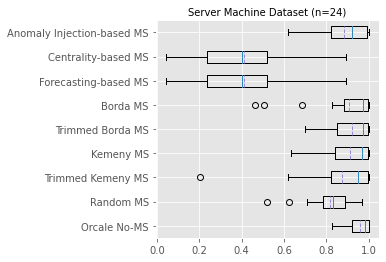

In [41]:
plt.style.use('ggplot')
fig, axes = plt.subplots(1, 1, figsize=(4, 4), sharey=True, sharex=True)
# plt.suptitle(f'%age of Best F-1 of Oracle with Model Selection', fontsize=16)

aggregate_stats = {'Trimmed Kemeny MS': [], 
                    'Kemeny MS': [], 
                    'Trimmed Borda MS': [], 
                    'Borda MS': [], 
                    'Oracle MS': [], 
                    'Random MS': [], 
                    'Forecasting-based MS': [], 
                    'Centrality-based MS': [], 
                    'Anomaly Injection-based MS': [], 
                    'Orcale No-MS': []}

# Let's find the model which performs the best on average
F1S = []
for entity in stats.keys():
    F1S.append(stats[entity]['Best F-1'])

F1S = np.array(F1S)
best_model_idx = np.argmax(np.mean(F1S, axis=0))

for entity in stats.keys():
    aggregate_stats['Trimmed Kemeny MS'].append(stats[entity]['Trimmed Kemeny Best F-1'][0])
    aggregate_stats['Kemeny MS'].append(stats[entity]['Kemeny Best F-1'][0]) 
    aggregate_stats['Trimmed Borda MS'].append(stats[entity]['Trimmed Borda Best F-1'][0])
    aggregate_stats['Borda MS'].append(stats[entity]['Borda Best F-1'][0]) 
    aggregate_stats['Oracle MS'].append(stats[entity]['Max Best F-1'])
    aggregate_stats['Random MS'].append(np.mean(stats[entity]['Best F-1']))
    aggregate_stats['Orcale No-MS'].append(stats[entity]['Best F-1'][best_model_idx])

# Compute Metric-wise performance
for entity in stats.keys():
    _forecasting_f1 = [] 
    _centrality_f1 = []
    _synthetic_f1 = []
    
    for m in stats[entity].keys(): 
        if ('Predicted' in m) and ('F-1' in m): 
            metric_class = m.split(' ')[-1][1:-1].split('_')[0]
            if metric_class == 'CENTRALITY': 
                _centrality_f1.append(stats[entity][m][0])
            elif metric_class == 'SYNTHETIC': 
                _synthetic_f1.append(stats[entity][m][0])
            elif metric_class in FORECASTING_METRIC_NAMES: 
                _forecasting_f1.append(stats[entity][m][0])

    aggregate_stats['Forecasting-based MS'].append(_forecasting_f1)
    aggregate_stats['Centrality-based MS'].append(_centrality_f1)
    aggregate_stats['Anomaly Injection-based MS'].append(_synthetic_f1)
    
for k, v in aggregate_stats.items():
    aggregate_stats[k] = np.array(v)

aggregate_stats['Forecasting-based MS'] = np.median(aggregate_stats['Forecasting-based MS'], axis=1)
aggregate_stats['Centrality-based MS'] = np.median(aggregate_stats['Centrality-based MS'], axis=1)
aggregate_stats['Anomaly Injection-based MS'] = np.median(aggregate_stats['Anomaly Injection-based MS'], axis=1)

# Compute ratios
aggregate_stats['Orcale No-MS/Oracle MS'] = aggregate_stats['Orcale No-MS']/(aggregate_stats['Oracle MS'] + 1e-6)
aggregate_stats['Random MS/Oracle MS'] = aggregate_stats['Random MS']/(aggregate_stats['Oracle MS'] + 1e-6)
aggregate_stats['Trimmed Kemeny MS/Oracle MS'] = aggregate_stats['Trimmed Kemeny MS']/(aggregate_stats['Oracle MS'] + 1e-6)
aggregate_stats['Kemeny MS/Oracle MS'] = aggregate_stats['Kemeny MS']/(aggregate_stats['Oracle MS'] + 1e-6)
aggregate_stats['Trimmed Borda MS/Oracle MS'] = aggregate_stats['Trimmed Borda MS']/(aggregate_stats['Oracle MS'] + 1e-6)
aggregate_stats['Borda MS/Oracle MS'] = aggregate_stats['Borda MS']/(aggregate_stats['Oracle MS'] + 1e-6)
aggregate_stats['Forecasting-based MS/Oracle MS'] = aggregate_stats['Forecasting-based MS']/(aggregate_stats['Oracle MS'] + 1e-6)
aggregate_stats['Centrality-based MS/Oracle MS'] = aggregate_stats['Centrality-based MS']/(aggregate_stats['Oracle MS'] + 1e-6)
aggregate_stats['Anomaly Injection-based MS/Oracle MS'] = aggregate_stats['Anomaly Injection-based MS']/(aggregate_stats['Oracle MS'] + 1e-6)

aggregate_stats['Orcale No-MS/Oracle MS'][aggregate_stats['Orcale No-MS/Oracle MS'] > 1] = 0
aggregate_stats['Random MS/Oracle MS'][aggregate_stats['Random MS/Oracle MS'] > 1] = 0
aggregate_stats['Trimmed Kemeny MS/Oracle MS'][aggregate_stats['Trimmed Kemeny MS/Oracle MS'] > 1] = 0
aggregate_stats['Kemeny MS/Oracle MS'][aggregate_stats['Kemeny MS/Oracle MS'] > 1] = 0
aggregate_stats['Trimmed Borda MS/Oracle MS'][aggregate_stats['Trimmed Borda MS/Oracle MS'] > 1] = 0
aggregate_stats['Borda MS/Oracle MS'][aggregate_stats['Borda MS/Oracle MS'] > 1] = 0
aggregate_stats['Forecasting-based MS/Oracle MS'][aggregate_stats['Forecasting-based MS/Oracle MS'] > 1] = 0
aggregate_stats['Centrality-based MS/Oracle MS'][aggregate_stats['Centrality-based MS/Oracle MS'] > 1] = 0
aggregate_stats['Anomaly Injection-based MS/Oracle MS'][aggregate_stats['Anomaly Injection-based MS/Oracle MS'] > 1] = 0

axes.set_title(f"Server Machine Dataset (n={len(aggregate_stats['Orcale No-MS/Oracle MS'])})", fontsize=10)    
_ = axes.boxplot([aggregate_stats['Orcale No-MS/Oracle MS'],
                    aggregate_stats['Random MS/Oracle MS'],
                    aggregate_stats['Trimmed Kemeny MS/Oracle MS'],
                    aggregate_stats['Kemeny MS/Oracle MS'],
                    aggregate_stats['Trimmed Borda MS/Oracle MS'],
                    aggregate_stats['Borda MS/Oracle MS'],
                    aggregate_stats['Forecasting-based MS/Oracle MS'],
                    aggregate_stats['Centrality-based MS/Oracle MS'],
                    aggregate_stats['Anomaly Injection-based MS/Oracle MS']
                    ], 
                vert=False, 
                bootstrap=10000,
                showmeans=True,
                meanline=True, 
                labels = [
                    'Orcale No-MS', 
                    'Random MS', 
                    'Trimmed Kemeny MS', 
                    'Kemeny MS', 
                    'Trimmed Borda MS', 
                    'Borda MS', 
                    'Forecasting-based MS',
                    'Centrality-based MS',
                    'Anomaly Injection-based MS'])

if metric == 'influence':
    plt.savefig(f"box_plot_{dataset}_{split}_{metric}_{aggregation_type}_{datetime.today().strftime(r'%H-%M-%m-%d-%Y')}.pdf", bbox_inches='tight')
else:
    plt.savefig(f"box_plot_{dataset}_{split}_{metric}_{datetime.today().strftime(r'%H-%M-%m-%d-%Y')}.pdf", bbox_inches='tight')
plt.show()